In [1]:
"""
Script to test loading an efr file in python and run the em_offset.py function on it to 
do the 50s fitting

"""


from scipy.io import loadmat
from scipy import signal
import numpy as np
import time
import pyIGRF
import datetime
import pandas as pd
import matplotlib.pyplot as plt
#from wavesim1d import *
from src.em_apex_processing import *
from src.spectral_processing import *
import os
import warnings

%load_ext autoreload
%autoreload 2

In [20]:



#########################
#####Define Constants####
#########################
Cmax=10
uVpc = 1e6 * (10e-3 / (2**24))

Nfit=1
nstep_off=25
navg_off=50
base_fr=0.02

ch=0.06
cz=0.09

nstep = 60 # I think this is the overlap?
#Andy sets navg (spectrum time windowing) to 120
navg = 120 #What is navg? I think this is the number of samples per window
Zmax=100
Dirmax=80
#electrode separation
esep1 = (8+5/8)*0.0254 # m
esep2 = (8+5/8)*0.0254 # m
c1 = 0.5
c2 = -0.2
# angles between compass and electrode axes
alpha2 = 1.95
alpha1 = alpha2 - np.pi/2

###########################


### Load Files ###
#For loading from harddrive
#fname_base = "/Volumes/TFO-5TB-3/TFO/LCDRI/raw_data/"
#For loading from laptop
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
save_dir = "/Volumes/TFO-5TB-3/TFO/LCDRI/processed_data/James_output/Spectra/"
float_list = os.listdir(fname_base)


#float_list = ['6667i']
#Loop through every float_id
big_spec_store = []
big_time_store = []
big_up_down_store = []
big_prof_store = []
float_id_counter = 0
ignore_count = 0
too_deep_counter = 0
min_bin = []
resid_store = np.array([])

##Testing for nans
fname_base = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/"
fname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0022-efr.mat"
gpsfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0022-gps.mat"
ctdfname = "/Users/jamesstadler/Documents/UW/TFO/Data/LCDRI/EmApex_Data/lcdri/6667i/dec/ema-6667i-0022-ctd.mat"


EFR = loadmat(fname)




efr_times = EFR['UXT'] - EFR['AGE']
efr_times = efr_times[0, :]
seqno = EFR['SEQNO'][0, :]

#Fit UXT times to sequence number (measurement # for that profile) to make sure monotonically increasing
p = np.polyfit(seqno,efr_times,1)
pfit = np.poly1d(p)
mlt_efr = pfit(seqno);

GPS = loadmat(gpsfname)
CTD = loadmat(ctdfname)

     

ctd_time = CTD["UXT"][0, :]
P = CTD["P"][0, :]
Pef = np.interp(mlt_efr, ctd_time, P)

tim_pd = pd.to_datetime(GPS["UXT_GPS"][0, :],unit='s', utc=True,)
#Convert time to fractional year for use in the igrf function
frac_yrs = np.array([year_fraction(dt) for dt in tim_pd])
avg_lat = np.nanmean(GPS["LAT"][0, :])
avg_lon = np.nanmean(GPS["LON"][0, :])
avg_frac_yrs = np.nanmean(frac_yrs)

#Get magnetic field values
[Bx, By, Bz, f] = pyIGRF.calculate.igrf12syn(avg_frac_yrs, 1, 0, avg_lat, avg_lon)

#get conversion factor for converting to velocity
fz=-np.nanmean(Bz);
fh=np.nanmean(np.sqrt(Bx**2+By**2));
sfv1 = 1e3/(fz*esep1*(1.0+c1));
sfv2 = 1e3/(fz*esep2*(1.0+c1));

#Convert from counts to microvolts
E1 = (EFR["E1"][0, :]-2**23) * uVpc;
E2 = (EFR["E2"][0, :]-2**23) * uVpc;

#pull out compass values
HZ = EFR["HZ"][0, :];
HY = EFR["HY"][0, :];
HX = EFR["HX"][0, :];
        

#Remove the beginning of the timesereis before the float starts moving
#Need to do this for all of E1, E2, HX, HY, mlt_efr
moving_inds = get_moving_inds(Pef)

#Uncomment this to print out the filenames where EM starts before CTD
#if len(moving_inds)<len(Pef):
    #print(len(Pef)-len(moving_inds), fname)
    #continue

#Apply moving_inds to the EM timeseries
E1 = E1[moving_inds]
E2 = E2[moving_inds]
HX = HX[moving_inds]
HY = HY[moving_inds]
mlt_efr = mlt_efr[moving_inds]
Pef_moving = Pef[moving_inds]
        
#Do the 50s fits 
[e1offs,e2offs,e1fits,e2fits,anghxhy, resid] = em_offset(Nfit,mlt_efr,nstep_off,navg_off,E1,E2,HX,HY);

#Get overall fi and calculate the residuals
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    e1off=np.nanmean(e1offs,1);
    e2off=np.nanmean(e2offs,1);
    e1fit=np.nanmean(e1fits,1);
    e2fit=np.nanmean(e2fits,1);
    resid = np.nanmean(resid,1);

#Calculate the residual
e1r = E1 - e1fit
e2r = E2 - e2fit

#Now need to convert to velocity (m/s)
e1r = e1r*sfv1
e2r = e2r*sfv2
        

#Now use the angles to rotate to x-y coordinates
avg_angs = np.copy(anghxhy)
avg_angs[~np.isnan(avg_angs)] = np.unwrap(avg_angs[~np.isnan(avg_angs)])
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    avg_angs = np.nanmean(avg_angs, axis=1)


E2_r=e2r*np.cos(avg_angs)+e1r*np.sin(avg_angs);
E1_r=-e2r*np.sin(avg_angs)+e1r*np.cos(avg_angs);

E_x = E1_r
E_y = E2_r

#Now try highpass filtering the data
sos = signal.butter(10, 0.04, 'hp', fs=1, output='sos')
E_x_filtered = signal.sosfilt(sos, E_x)
E_y_filtered = signal.sosfilt(sos, E_y)

E_x = E_x_filtered
E_y = E_y_filtered
        
    
##Get the mean residual level below 90m for the purpose of estimating error
deep_inds = np.where(Pef_moving>=90)
error = np.sqrt(np.square(e1r[deep_inds])+np.square(e2r[deep_inds]))
resid_store = np.append(resid_store, error)


#Now take the spectra
nblock = 120
fs = 1
overlap = 60




[u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)

[u_x, z_x] = reshape_u(E_x, Pef, nblock, overlap, fs)

#prof_speed is a numpy array that stores the mean vertical velocity (in m/s)
#for each spectral window
#Throwaway to get t_new in the same shape as u_x and z_x for calculating mean profiling speed
[u_x_temp, t_new] = reshape_u(E_x, mlt_efr, nblock, overlap, fs)

prof_speed = np.abs(z_x[:, 0]-z_x[:, -1])/np.abs(t_new[:, 0]-t_new[:, -1])


UUwindow, fwindow = make_vel_spectrum(u_x, fs)

[u_y, z_y] = reshape_u(E_y, Pef, nblock, overlap, fs)

VVwindow, fwindow = make_vel_spectrum(u_y, fs)


UU = UUwindow/(int(nblock/2)*fs)
Exx = UU[:,1:]/ (np.square((2*np.pi*fwindow[1:])))
VV = VVwindow/(int(nblock/2)*fs)
Eyy = VV[:,1:]/ (np.square((2*np.pi*fwindow[1:])))

Eh = Exx+Eyy


[Eh_Eric1, Eh_Eric2, Eh_Eric3, Eh_Eric4] = depth_correct_Eric(Eh, fwindow[1:], z_x, prof_speed, nblock, Cmax, fs)

u_noise = 0 #This is just for testing...
[lbound, ubound] = get_spectral_uncertainity(E_x, E_y, Pef, u_noise, prof_speed, nblock, overlap, Cmax, fs)

with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        avg_spec = np.nanmean(Eh_Eric4, axis=0)



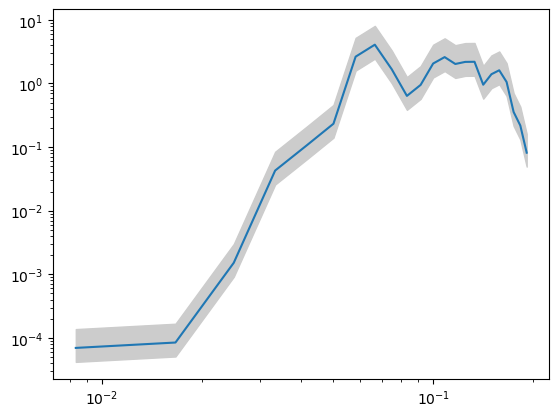

In [21]:
plt.figure()
plt.fill_between(fwindow[1:],avg_spec*ubound,avg_spec*lbound,color='0.8')
plt.loglog(fwindow[1:], avg_spec)

In [10]:
avg_spec

array([9.34598457e-03, 1.46445972e-02, 3.54402013e-01, 5.96736264e+00,
       2.74159221e+01, 3.90699694e+01, 4.52630509e+01, 6.90047851e+01,
       9.57007140e+01, 2.00127173e+02, 3.83201753e+02, 8.74241273e+01,
       7.77324321e+00, 1.29670656e+01, 9.80506902e+00, 5.13390532e+00,
       1.39153433e+00, 1.73898096e+00, 1.36909842e+00,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
      

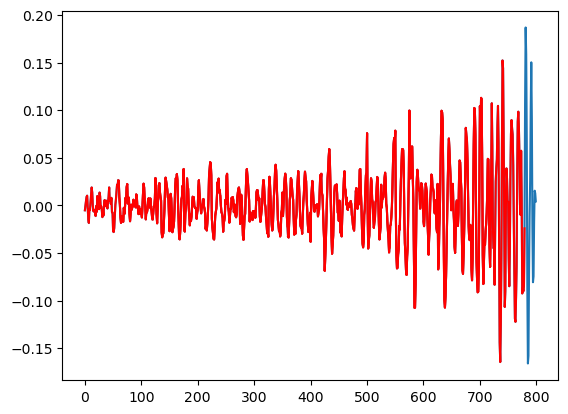

In [27]:
plt.plot(E_x)
for ind in range(u_x.shape[0]):
    x_ind = np.arange(60*ind, 60*ind+120, 1)
    plt.plot(x_ind, u_x[ind, ], 'r')

In [26]:
u_x[-1, :]

array([-0.00254648, -0.02152466, -0.00752261,  0.0283677 ,  0.04711259,
        0.04513373,  0.02891234,  0.01754131, -0.03161763, -0.06812157,
       -0.07183375, -0.05267648, -0.02884655,  0.00109011,  0.03110297,
        0.08139635,  0.07313926,  0.06860929,  0.04649773,  0.0093408 ,
       -0.02163382, -0.03549919, -0.03643781, -0.02041359, -0.02588312,
       -0.06658202, -0.07859452, -0.05616794,  0.00332666,  0.0634757 ,
        0.10229076,  0.10110388,  0.0738697 ,  0.00304016, -0.05889567,
       -0.0794399 , -0.09118599, -0.09060479, -0.06605679,  0.01164578,
        0.10433585,  0.07333928,  0.11290513,  0.11154215,  0.04736029,
       -0.0517181 , -0.08248301, -0.0620053 , -0.03609092, -0.04148446,
       -0.02741341, -0.01963599, -0.00800694,  0.01406629,  0.04885833,
        0.04820473,  0.0067811 , -0.04342972, -0.06458846, -0.02733708,
        0.04694265,  0.10723504,  0.06199149, -0.02276532, -0.04486181,
       -0.04430603, -0.0833092 , -0.02615665,  0.0251478 ,  0.03